<div>
<img src="./images/logos3.png"  width="600"/>
</div>

# <p style='text-align: right;'> Icing Detection from the Geostationary Operational Environmental Satellite (GOES-16) <br><br>Part III: Convolutional Neural Network </p>

## <p style='text-align: right;'> Katherine Haynes <br> CS 540 Project <br> April 30, 2020</p> 


# 1 Introduction

GOES-16 is positioned at 75.2$^{\circ}$ W with a view of the Western Hemisphere, and the ABI has two different modes of collecting data.  In scan mode, the ABI can take a full disk image every 10 minutes, an image of the continguous U.S. every 5 minutes, and two smaller, more detailed images every 60 seconds.  With these mesoscale images, GOES-16 provides coverage over a 1000 x 1000 km box at a spatial resolution of 0.5 to 2 km.  Alternately, ABI can provide continuous images of the full disk every 5 minutes, also with a spatial resolution of 0.5 to 2 km. 

![](./images/GOES_FullDisc.png)

With its continuous high-resolution spatial coverage over the US, GOES-16 has the potential to provide data that can be used to identify and predict icing, a meteorological condition that has important aviation implications.  Icing conditions are dangerous for aircrafts, disturbing their balance and potentially leading to loss of control, accidents, and fatalities.  Accurately predicting this phenomena would provide a huge benefit to the aviation industry; however, this is a difficult problem that will likely require deep machine learning, if it is even possible.

Although in-flight warning systems are essential for aviation safety, improvements in predicting icing conditions have been few and far between based on our findings in literature.  In 2009, Serke et al. improved the operational hazard detection system produced by the NASA Icing Remote Sensing System (NIRSS) by adding X-band radar reflectivy profiles to help detect cloud levels and small-drop icing conditions. In 2012, Smith et al. created the first flight icing threat (FIT) algorithm using GOES satellite data.   They utilized GOES satellite-derived cloud products including effective temperature, cloud-top phase, liquid water path, and effective radius, to develop a physically-based empirical icing method.  Using pilot reports (PIREPs), Tropospheric Airborne Meteorological Data Reporting (TAMDAR), and NIRSS data for evaluation, daytime satellite icing detection accuracies are found to range between 58-75%.  They were able to obtain 90% accuracies when they used satellite-derived cloud microphysical properties to screen out cases obscured by high ice clouds; however, combining this information for real-time warnings is still a topic for future research.  Finally, in 2018 Sim et al. propose a machine-learning-based icing detection model using data from two geostationary satellites (Communication, Ocean, and Meteorological Satellite Meteorological Imager; COMS-MI and Advanced Himawari Imager; AHI).  Using random forests and multinomial log-linear models compared against PIREPs, they were able to obtain a mean probability of detection (POD) of 81.8%, a mean overall accuracy (OA) of 82.1% and mean true skill statistics (TSS) of 64%. 

To take advantage of the continuous high-resolution spatial images from GOES-16 that are updated every 15 minutes over the entire continental US, it is a high priority task to develop methods that can detect and predict icing conditions.  With recent advances in computing resources and algorithms for processing big data, this is becoming possible  This project will evaluate the potential of ice prediction from GOES-16 satellite data focusing on three main tasks: 

- <b> Model Search.</b>  Perform a model search using various different pre-processing and feature selection techniques, 7 different classifier algorithms, and a suite of model optimization parameters. <br><br>

- <b> Classification Neural Network.</b>  Develop and train a classification neural network. <br><br>

- <b> Convolutional Neural Network.</b>  Use satellite images to develop and train a CNN, attempting to learn surrounding conditional patterns associated with icing to aid the predictions.

# 2 Data


### Target Data:
Known icing conditions are difficult to obtain and thus drive the data used in this study.  After investigating how the most recent publications evaluated icing predictions, I decided to use pilot weather reports (PIREPs) as the target dataset.  All reports are grouped into two categories (0=no ice and 1=icing).  After an initial assessment of the dataset, it became apparent that most reports are made during take-off and landing, which happens near airports.  It should be noted that while pilots are urged to report icing conditions, it is not mandatory.  While this is a deterrent for using this dataset, I hope to minimize any potential biases by using popular airports.

With this in mind, I investigated two airports that are busy and have substantial delays and cancellations due to icing:
- Buffalo, NY (BUF)
- Detroit, MI (DTW)

Since both of these airports have relatively continuous air traffic, I grouped the reports into 15-minute intervals.  To correspond with GOES-16 data, I used reports from January 1, 2018 through November 7, 2019.  Since the GOES-16 ABI is a passive instrument, I only used daytime data, requiring a solar elevation angle > 15$^{\circ}$. Since icing only occurs during the winter, we limited the dataset to  six winter months (January through March and October through December).


### Input Data:
For input data, I will use matched GOES-16 satellite data from 15 different channels.  Centering on each airport, I will use 51 x 51 pixel images.  To supplement the satellite data, I will use forecast temperatures from the Hi-Resolution Rapid Refresh (HRRR) 1-hour model forecast at 39 altitudes.

### Sample Buffalo Scene
The image below is a sample scene from Buffalo, NY.  The map on the right side shows the region, and the red box shows the size of the GOES-16 image (centered on the airport).  The images on the left are the GOES-16 data from each channel.  There is icing at the airport, indicated by a target of 1.0.
![](images/buf_slide.png)

### Sample Detroit Scene
The image below is a sample scene from Detroit, MI.  In this snapshot, there is not icing at the airport.
![](images/det_slide.png)

### Setup Google Drive

In [1]:
useGoogle = False

In [2]:
# Set directories
if useGoogle:
    from google.colab import drive
    drive.mount('/content/drive')
    dirIn = '/content/drive/My Drive/classes/cs540/Project/'
else:
    dirIn = './'

### Load Libraries

In [3]:
# Load Libraries
from functools import partial
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
if useGoogle:
    !pip install netCDF4
import netCDF4
import numpy as np
import os
import pandas as pd
import pickle
import pydot
import pydotplus
import seaborn as sns
import sys
import time

from hyperopt import fmin, hp, Trials, tpe, space_eval, STATUS_OK
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [4]:
# Set Tensorflow Options
tf.keras.backend.set_floatx('float32')
tf.keras.backend.set_image_data_format('channels_last')
if useGoogle:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print('Using GPU!')
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

In [5]:
# Set Plotting Sizes
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [6]:
# Set Plotting Colors
myColors = ['darkblue','slateblue','darkviolet','fuchsia','crimson',
            'orangered','goldenrod','darkolivegreen','darkslategrey']

mpl.rcParams['figure.figsize'] = (12, 10)
#myColors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Define Data Functions

In [7]:
# Function to read in data
def read_data(dataSet='', chToSave=[]):
    
    if useGoogle:
        filenames= [dirIn + 'data/bufdat_v01.nc',
                    dirIn + 'data/dtwdat_v01.nc']
    else:
        filenames= ['/Users/kdhaynes/Data/cs540/GOES/bufdat_v01.nc',
                    '/Users/kdhaynes/Data/cs540/GOES/dtwdat_v01.nc']
    
    if dataSet == 'BUF':
        filenames = filenames.pop()
 
    elif dataSet == 'DTW':
        filenames = filenames.pop(0)

    
    if type(filenames) == str:
        filenames = [filenames]
        
    for file in filenames:
        
        # Read in data from file
        dataset = netCDF4.Dataset(file)
        X = np.array(dataset.variables['data'][:], dtype='float32')
        X = np.moveaxis(X, 3, 0)
        X = np.moveaxis(X, 3, 1)
        Solzen = np.array(dataset.variables['data_solzen'])
        Temperature = np.array(dataset.variables['data_temperature'])
        Temperature = np.moveaxis(Temperature, 1, 0)
        T = np.array(dataset.variables['data_ice_targets']).astype(np.uint8)
        dataset.close()
        
        # Combine solzen and temperature
        Tshape = list(Temperature.shape)
        nSamples = Tshape[0]
        nTemps = Tshape[1]
        
        Temp = np.empty([nSamples,nTemps+1])
        Temp[:,:nTemps] = Temperature[:,:]
        Solzen.resize([Solzen.shape[0],1])
        Temp[:,nTemps:] = Solzen[:,:]
        
        # Replace some bad values
        baseName = os.path.basename(file)
        if (baseName == 'bufdat_v01.nc'):
            badpoints = [80,426,1798,1799,3092,3996,5881,8022,9308,9309]
        elif (baseName == 'dtwdat_v01.nc'):
            badpoints = [67,421,664,2555,3091,3092,3093,3094,3095,
                         3096,3097,3098,3099,3100,4013,9374,9375]
        else:
            badpoints = []
            
        for t in badpoints:
            X[t,:,:,:] = X[t-1,:,:,:]
            T[t] = T[t-1]
            
        # Only save positive values
        X[np.where(X < 0.0)] = 0.0
        
        # Only save specified channels
        if (len(chToSave) > 0):
            X = X[:,chToSave,:,:]
            
        # Concatinate datasets
        if (file == filenames[0]):
            Xall = X
            Tempall = Temp
            Tall = T
        else:
            Xall = np.concatenate((Xall,X), axis=0)
            Tempall = np.concatenate((Tempall, Temp), axis=0)
            Tall = np.concatenate((Tall,T), axis=0)
        
    return Xall, Tempall, Tall

In [8]:
# Function to partition data including temperature
def partition_data(Xall, Tempall, Tall, part50=False, trainFraction=0.8):
    iceI = np.where(Tall == 1)[0]
    noiceI = np.where(Tall == 0)[0]
    iceI = np.random.permutation(iceI)
    noiceI = np.random.permutation(noiceI)
    nIceAll = round(len(iceI))
    nNoIceAll = round(len(noiceI))
    nIce = round(trainFraction*nIceAll)
    nNoIce = round(trainFraction*nNoIceAll)
    
    if part50:
        rowsTrain = np.hstack((iceI[:nIce], noiceI[:nIce]))
        rowsTest = np.hstack((iceI[nIce:], noiceI[nIce:nIceAll]))
    else:
        rowsTrain = np.hstack((iceI[:nIce], noiceI[:nNoIce]))
        rowsTest = np.hstack((iceI[nIce:], noiceI[nNoIce:]))
                  
    nTrain = rowsTrain.shape[0]
    XTrain = Xall[rowsTrain,:,:,:]
    TTrain = Tall[rowsTrain]
    TempTrain = Tempall[rowsTrain,:]
    
    nTest = rowsTest.shape[0]
    XTest = Xall[rowsTest,:,:,:]
    TTest = Tall[rowsTest]
    TempTest = Tempall[rowsTest,:]

    # Check train/test distributions
    iceITr = np.where(TTrain == 1)[0]
    noiceITr = np.where(TTrain == 0)[0]
    nIceTr = round(len(iceITr))
    nnoIceTr = round(len(noiceITr))
    print('Data Stats:')
    print('  Orig X Shape: {}, Train X: {}, Test X: {}'.format(
        list(Xall.shape), list(XTrain.shape), list(XTest.shape)))
    print('  Orig Y Shape: {}, Train  Y: {}, Test Y: {}'.format(
        list(Yall.shape), list(YTrain.shape), list(YTest.shape)))
    print('  Train Ice: {}, No Ice: {} ({:.3f}% ice) '.format(
        nIceTr, nnoIceTr, float(100.*nIceTr/(nIceTr+nnoIceTr))))
    
    iceI = np.where(TTest == 1)[0]
    noiceI = np.where(TTest == 0)[0]
    nIceTest = round(len(iceI))
    nnoIceTest = round(len(noiceI))
    print('  Test Ice: {}, No Ice: {} ({:.3f}% ice)'.format(
        nIceTest, nnoIceTest, float(100*nIceTest/(nIceTest + nnoIceTest))))
    
    print('  Train: {}, Test: {} ({:.0f}% Test)'.format(
          nTrain, nTest, float(nTest/(nTest + nTrain))*100.))
    
    return XTrain, TempTrain, TTrain, XTest, TempTest, TTest

In [9]:
# Function to partition X and Y data only
def partition_XY(Xall, Yall, part50=False, trainFraction=0.8):
    iceI = np.where(Yall == 1)[0]
    noiceI = np.where(Yall == 0)[0]
    iceI = np.random.permutation(iceI)
    noiceI = np.random.permutation(noiceI)
    nIceAll = round(len(iceI))
    nNoIceAll = round(len(noiceI))
    nIce = round(trainFraction*nIceAll)
    nNoIce = round(trainFraction*nNoIceAll)
    
    if part50:
        rowsTrain = np.hstack((iceI[:nIce], noiceI[:nIce]))
        rowsTest = np.hstack((iceI[nIce:], noiceI[nIce:nIceAll]))
    else:
        rowsTrain = np.hstack((iceI[:nIce], noiceI[:nNoIce]))
        rowsTest = np.hstack((iceI[nIce:], noiceI[nNoIce:]))
                  
    nTrain = rowsTrain.shape[0]
    XTrain = Xall[rowsTrain,:,:,:]
    YTrain = Yall[rowsTrain]

    nTest = rowsTest.shape[0]
    XTest = Xall[rowsTest,:,:,:]
    YTest = Yall[rowsTest]
    
    # Check train/test distributions
    iceITr = np.where(YTrain == 1)[0]
    noiceITr = np.where(YTrain == 0)[0]
    nIceTr = round(len(iceITr))
    nnoIceTr = round(len(noiceITr))
    print('Data Stats:')
    print('  Orig X Shape: {}, Train X: {}, Test X: {}'.format(
        list(Xall.shape), list(XTrain.shape), list(XTest.shape)))
    print('  Orig Y Shape: {}, Train  Y: {}, Test Y: {}'.format(
        list(Yall.shape), list(YTrain.shape), list(YTest.shape)))
    print('  Train Ice: {}, No Ice: {} ({:.3f}% ice) '.format(
        nIceTr, nnoIceTr, float(100.*nIceTr/(nIceTr+nnoIceTr))))
    
    iceI = np.where(YTest == 1)[0]
    noiceI = np.where(YTest == 0)[0]
    nIceTest = round(len(iceI))
    nnoIceTest = round(len(noiceI))
    print('  Test Ice: {}, No Ice: {} ({:.3f}% ice)'.format(
        nIceTest, nnoIceTest, float(100*nIceTest/(nIceTest + nnoIceTest))))
    
    print('  Train: {}, Test: {} ({:.0f}% Test)'.format(
          nTrain, nTest, float(nTest/(nTest + nTrain))*100.))
    
    return XTrain, YTrain, XTest, YTest

In [10]:
# Function to shuffle three arrays
def shuffle_data(a, b, c):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

In [11]:
# Function to shuffle two arrays
def shuffle_XY(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [12]:
# Function to resize data
def resize_data(imOpt, Xall, Tempall, reorder=True, verbose=False):
   
    # Find sizes
    XShape = list(Xall.shape)
    nSamples = XShape[0]
    nChannels = XShape[1]
    nImageX = XShape[2]
    nImageY = XShape[3]
    nTemps = Tempall.shape[1]
    if verbose:
        print('  Original Shape: {}'.format(XShape))
        print('  Original Samples: {}'.format(nSamples))
        print('  Original Channels: {}, Temperatures: {}'.format(nChannels,nTemps))
        print('  Original Image X: {}, Y: {}'.format(nImageX,nImageY))
    
    labelNew = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8',
                'CH9','CH10','CH11','CH12','CH13','CH14','CH15',
                'CH16']
    
    # First normalize the data
    Xall_ = normalize_data(Xall)
    Tempall_ = normalize_data(Tempall)
    Tempall2_ = normalize_data(Tempall,all=True)
    
    # Now resize
    if imOpt == 0:
        # Leave as-is
        XNew = np.empty([nSamples,nChannels,nImageX,nImageY])
        XNew[:,:,:,:] = Xall_[:,:,0:nImageX,0:nImageY]

    elif imOpt == 1:
        # Make square
        nImage = min(nImageX,nImageY)
        nImageX = nImage
        nImageY = nImage
        XNew = np.empty([nSamples,nChannels,nImage,nImage])
        XNew[:,:,:,:] = Xall_[:,:,0:nImage,0:nImage]

    elif imOpt == 2:
        # Leave as-is and add in temperature
        XNew = np.zeros([nSamples,nChannels+2,nImageX,nImageY])
        XNew[:,:nChannels,:,:] = Xall_[:,:,0:nImageX,0:nImageY]
        labelNew.append('TEMP')
        labelNew.append('TEMPA')
        
        for j in range(nImageY):
            XNew[:,nChannels,:nTemps,j] = Tempall_[:,:]
            XNew[:,nChannels+1,:nTemps,j] = Tempall2_[:,:]
    
    elif imOpt == 3:
        # Make square and add in temperature
        nImage = min(nImageX,nImageY)
        nImageX = nImage
        nImageY = nImage
        XNew = np.zeros([nSamples,nChannels+2,nImage,nImage])
        XNew[:,:nChannels,:,:] = Xall_[:,:,0:nImage,0:nImage]
        labelNew.append('TEMP')
        labelNew.append('TEMPA')
        
        for j in range(nImage):
            XNew[:,nChannels,:nTemps,j] = Tempall_[:,:]
            XNew[:,nChannels+1,:nTemps,j] = Tempall2_[:,:]
    else:
        print("Invalid Resize Option!")
        sys.exit()

    if verbose:
        nFeats = XNew.shape[1]
        print('  New Features: {}'.format(nFeats))
        print('  New Image Size: {}x{}'.format(nImageX,nImageY))
        
        if len(labelNew) != nFeats:
            print("ERROR WITH FEATURE LABELS. STOPPING.")
            sys.exit()
        else:
            print('  Features: {}'.format(labelNew))
    
    if reorder:
        XNew = np.moveaxis(XNew, 1, -1)

        if verbose:
            print('Reordered array!  New Shape: {}'.format(list(XNew.shape)))
            
    return XNew, labelNew


In [13]:
# Function to normalize data
def normalize_data(XData, all=False):
    
    xsize=XData.shape
    xdim=len(xsize)
    
    nSamples=xsize[0]
    nChannels=xsize[1]
    if xdim == 2:
        XDataNew = np.empty([nSamples,nChannels])
        if all:
            maxD = np.max(XData)
            minD = np.min(XData)
            diffD = maxD-minD
            if diffD < 0.01:
                print('Min Var in Variable! Stopping.')
                sys.exit()
            XDataNew[:,:] = (XData[:,:] - minD)/diffD
        else:
            for ch in range(nChannels):
                maxD = np.max(XData[:,ch])
                minD = np.min(XData[:,ch])
                diffD = maxD-minD
                if diffD < 0.01:
                    print('Min Var in Channel {}! Stopping.'.format(ch))
                    sys.exit()
            
                XDataNew[:,ch] = (XData[:,ch] - minD)/diffD

    elif xdim == 4:
        nImgX=xsize[2]
        nImgY=xsize[3]
        XDataNew = np.empty([nSamples,nChannels,nImgX,nImgY])
        for ch in range(nChannels):
            maxD = np.max(XData[:,ch,:,:])
            minD = np.min(XData[:,ch,:,:])
            diffD = maxD-minD
            if diffD < 0.01:
                print('Min Var in Channel {}! Stopping.}'.format(ch))
                sys.exit()
            XDataNew[:,ch,:,:] = (XData[:,ch,:,:] - minD)/diffD

    else:
        print("Unexpected dimension in normalize. Stopping.")
        sys.exit()

    return XDataNew

In [14]:
# Function to select data
def select_data(X, Temp, params):
    if 'imsize' in params:
        nImOpt = params['imsize']
    else:
        nImOpt = 0
        
    X_, XLabels = resize_data(nImOpt, X, Temp)
    
    return X_, XLabels

In [15]:
# Function to select channels
def select_channels(X, chList, reorder=True, verbose=False):
    
    nChNew = len(chList)
    shapeX = list(X.shape)
    nSamples = shapeX[0]
    if reorder:
        nImX = shapeX[1]
        nImY = shapeX[2]
        nCh = shapeX[3]
        
        X_ = np.empty([nSamples,nImX,nImY,nChNew])
        count=0
        for ch in chList:
            X_[:,:,:,count] = X[:,:,:,ch]
            count+=1
            
    else:
        nCh = shapeX[1]
        nImX = shapeX[2]
        nImY = shapeX[3]
        
        X_ = np.empty([nSamples,nChNew,nImX,nImY]) 
        count=0
        for ch in chList:
            X_[:,count,:,:] = X[:,ch,:,:]
            count+=1
            
    if verbose:
        print('Selected Select Channels!')
        print('  Original Shape: {} and New Shape: {}'.format(shapeX,list(X_.shape)))
        
    return X_

In [16]:
# Function to report if variable exists
def exists(var):
    var_exists = var in locals() or var in globals()
    return var_exists

In [17]:
# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = 0.90
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    return figure

In [18]:
# Plot sample satellite images
def plot_sample_images(X_, Y, channelPlot=0, reorder=True):

    XLabel = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8',
                'CH9','CH10','CH11','CH12','CH13','CH14','CH15',
                'CH16','TEMP','TEMPA']
    
    nSamples = Y.shape[0]-1
    tplot = np.random.permutation(nSamples)
    
    plt.figure(figsize=(18,12))
    for i in range(4):
        iRef = tplot[i]
        
        plt.subplot(2, 2, i+1)
        if reorder:
            plt.imshow(X_[iRef,:,:,channelPlot])
        else:
            plt.imshow(X_[iRef,channelPlot,:,:])

        plt.title(XLabel[channelPlot] + ' (Target: {})'.format(Y[iRef]))
        plt.axis('off')
        plt.colorbar()

In [19]:
# Plot sample scene in all channels
def plot_scene_all_channels(X, T, reorder=True):

    nShere = X.shape[0]
    
    if reorder:
        nChere = X.shape[3]
    else:
        nChere = X.shape[1]
        
    tplot = np.random.permutation(nShere)
    iRef = tplot[0]
    print('Plotting image: {}'.format(iRef))
    
    if nChere == 3 or nChere == 5:
        plt.figure(figsize=(10,10))
        for i in range(3):
            plt.subplot(1,3,i+1)
            if reorder:
                plt.imshow(X[iRef,:,:,i])
            else:
                plt.imshow(X[iRef,i,:,:])
            
            plt.title('C{}  Target: {}'.format(
                i+1, int(T[iRef])))
            plt.axis('off')
        plt.show()
        
    if nChere >= 16:
        plt.figure(figsize=(16,16))
        for i in range(16):
            plt.subplot(4,4,i+1)
            if reorder:
                plt.imshow(X[iRef,:,:,i])
            else:
                plt.imshow(X[iRef,i,:,:])
            
            plt.title('C{}  Target: {}'.format(
                i+1, int(T[iRef])))
            plt.axis('off')
        plt.show()
        
    if nChere == 5 or nChere > 16:
        tTitle = ['TEMP','TEMPA']
        plt.figure(figsize=(7,7))
        for i in range(2):
            plt.subplot(1,2,i+1)
            if reorder:
                plt.imshow(X[iRef,:,:,-2+i])
            else:
                plt.imshow(X[iRef,-2+i,:,:])
                
            plt.title('{}  Target: {}'.format(
                tTitle[i], int(T[iRef])))
            plt.axis('off')
            
    #plt.colorbar()

### Select Airport and Load Data

In [20]:
dataSet = 'DTW'

In [21]:
# Open and Read the Data Set
Xall, Tempall, Yall = read_data(dataSet=dataSet)
print('Finished Loading {} Dataset.'.format(dataSet))
print('   X Min: {}, X Max: {}'.format(np.min(Xall), np.max(Xall)))
print('   Temp Min: {}, Temp Max: {}'.format(np.min(Tempall),np.max(Tempall)))

neg, pos = np.bincount(Yall)
total = neg + pos
print('   Total Examples: {}, Positive: {} ({:.2f}%)'.format(total, pos, 100*pos/total))
print('   Image Size: {} x {}'.format(Xall.shape[2],Xall.shape[3]))

Finished Loading DTW Dataset.
   X Min: 0.0, X Max: 311.0882873535156
   Temp Min: 38.694400787353516, Temp Max: 301.0249938964844
   Total Examples: 9513, Positive: 1385 (14.56%)
   Image Size: 51 x 81


### Pre-Process Data

In [22]:
preprocess=True
imSave=2
chToSave=[1,7,12]

In [23]:
# Pre-Process First
if preprocess:
    oShape = list(Xall.shape)
    Xall = select_channels(Xall, chToSave, reorder=False)
    Xall, XLabels = resize_data(imSave, Xall, Tempall)
    del Tempall
    nShape = list(Xall.shape)
    print('Pre-Processed Data.')
    print('  Original Shape: {}'.format(oShape))
    print('  New Shape: {}'.format(nShape))

Pre-Processed Data.
  Original Shape: [9513, 16, 51, 81]
  New Shape: [9513, 51, 81, 5]


### Plot Data

In [83]:
plotLabelHist = False
plotSampleScene = False
plotSampleChannels = True

In [84]:
# Show Label Histogram
if plotLabelHist:
    histNums, histOut = np.unique(Yall, return_counts=True)
    plt.figure(figsize=[6,6])
    plt.bar(histNums,histOut)
    plt.title(dataSet)
    plt.ylabel('Number')
    plt.xlabel('Classification')
    plt.xticks([0,1],labels=['0','1'])

In [85]:
# Plot four scenes for one channel
if plotSampleScene:
    chToPlot = 16
    imSize = 3  # choices 0-3

    if not exists('X_') or not exists('imSizeP'):
        imSizeP = imSize
        X_, XLabels = resize_data(imSize, Xall, Tempall, verbose=True)

    else:
        if imSize != imSizeP:
            imSizeP = imSize
            X_, XLabels = resize_data(imSize, Xall, Tempall, verbose=True)

    plot_sample_images(X_, Yall, channelPlot=chToPlot)

Plotting image: 9368


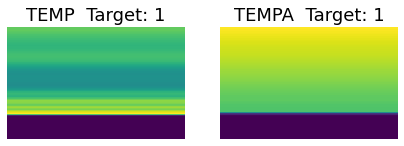

In [86]:
# Plot a scene for all channels
if plotSampleChannels:

    if not preprocess:
        imSize = 2  # choices 0-3
        if not exists('X_') or not exists('imSizeP'):
            imSizeP = imSize
            X_, XLabels = resize_data(imSize, Xall, Tempall, verbose=True)

        else:
            if imSize != imSizeP:
                imSizeP = imSize
                X_, XLabels = resize_data(imSize, Xall, Tempall, verbose=True)

        plot_scene_all_channels(X_, Yall)
    else:
        plot_scene_all_channels(Xall, Yall)

### Split Data into Training and Testing

For this study, I used 80% of the data for training and 20% for testing.  Since icing at both airports is imbalanced, care was taken to ensure both subsets maintain the original classification distribution.  Additionally, all evaluation will be done using the balanced accuracy scoring method.

In [24]:
trainFrac = 0.8
shuffleData = True

In [25]:
# Make a train/test split
if preprocess:
    XTrain, YTrain, XTest, YTest = \
        partition_XY(Xall, Yall, trainFraction=trainFrac)
else:
    XTrain, TempTrain, YTrain, XTest, TempTest, YTest = \
        partition_data(Xall, Tempall, Yall, trainFraction=trainFrac)

Data Stats:
  Orig X Shape: [9513, 51, 81, 5], Train X: [7610, 51, 81, 5], Test X: [1903, 51, 81, 5]
  Orig Y Shape: [9513], Train  Y: [7610], Test Y: [1903]
  Train Ice: 1108, No Ice: 6502 (14.560% ice) 
  Test Ice: 277, No Ice: 1626 (14.556% ice)
  Train: 7610, Test: 1903 (20% Test)


In [26]:
# Shuffle the data
if shuffleData:
    if  preprocess:
        shuffle_XY(XTrain, YTrain)
        shuffle_XY(XTest, YTest)
    else:
        shuffle_data(XTrain, TempTrain, YTrain)
        shuffle_data(XTest, TempTest, YTest)
    print("Shuffled Data!")

Shuffled Data!


# 3 CNN Hyperparameter Search Space


### Input Data Features 
Input data features are options during the data pre-processing phase. <br>
This search space consists of two elements:
* <b>Image Size.</b>
The size of the image surrounding the airport is varied between square and rectangular.<br>
hp.choice('imsize', [0,1,2,3]), where 1 and 3 are square (0 and 2 use original image size).  <br><br>

* <b>Number of Features.</b>
Temperature information can be added in with the channels to add two additional features. <br>
hp.choice('imsize', [0,1,2,3]), where 2 and 3 have the added temperature information.<br>


### Network Architecture Features 
Architecture features are options associated with the neural network setup. <br>
This search space consists of three elements:

* <b>Dropout Rate</b><br>
Use a uniform distribution in finding an appropriate dropout value. <br>
hp.uniform('dropout', 0.0, 0.4) <br><br>

* <b>Number of Convolutional Layers</b><br>
Determine the number of hidden convolutional layers, ranging from 1 to 8.<br>
hp.choice('nconv2d', range(8)) <br><br>

* <b>Pooling Layer</b><br>
Select whether to add a pooling layer after the convolutional layer. <br>
hp.choice('pool',[0,1]) <br>


### Network Parameters
Parameters are options associated with the CNN implementation. <br>
This search space consists of six elements:

* <b>Batch Size</b><br>
Vary the batch size fed for each gradient update from 100 to 700, incrementing by 5.<br>
hp.quniform('batch_size', 100, 700, 5)<br><br>

* <b>Beta 1</b><br>
Vary the exponential decay rate for the 1st moment estimates, ranging from 0.8 to 1.0.<br>
hp.uniform('beta_1', 0.8, 1.0)<br><br>

* <b>Beta 2</b><br>
Vary the exponential decay rate for the 2nd moment estimates, ranging from 0.9 to 1.0.<br>
hp.uniform('beta_2', 0.9, 1.0)<br><br>

* <b>Convolutional Kernel X Size</b><br>
Vary the size of the convolutional kernel x-size, ranging from 2 to 5. <br>
hp.choice('nkernelx', range(2,6))<br><br>

* <b>Convolutional Kernel Y Size</b><br>
Vary the size of the convolutional kernel y-size, ranging from 2 to 5. <br>
hp.choice('nkernely', range(2,6))<br><br>

* <b>Convolutional Stride X Size</b><br>
Vary the stride of the convolutional kernel in the x-direction, ranging from 1 to 5.<br>
hp.choice('stridex', range(1,5))<br><br>

* <b>Convolutional Stride Y Size</b><br>
Vary the stride of the convolutional kernel in the y-direction, ranging from 1 to 5.<br>
hp.choice('stridey', range(1,5))<br><br>

* <b>Initial Accumulator Value</b><br>
Vary the initial accumulator value for the Adagrad optimizer using a multiplier on the default value of 0.1.
hp.loguniform('iacc_mult', -0.2, 0.2)<br><br>

* <b>Learning Rate</b><br>
Vary the learning rate, using a loguniform scale to make it vary exponentially in a multiplicative fashion. <br>
hp.loguniform('lr_mult', -0.5, 0.5) <br><br>

* <b>Number of Epochs</b><br>
Vary the number of epochs for training, ranging from 10 to 200.<br>
hp.choice('nepochs', [10,20,40,60,80,100,120,150,200])<br><br>

* <b>Number of Hidden Units</b><br>
Vary the number of hidden units, specifying the number using a range.<br>
hp.choice('nhidden', range(8,160) <br><br>

* <b>Optimizer</b><br>
Select from three different optimizer options: Adagrad, Adam, and NAdam. <br>
hp.choice('optimizer', ['Adagrad','Adam','Nadam']) <br><br>



## Search Method: [Hyperopt](http://jaberg.github.io/hyperopt/)
The data pre-processing, network building components, and model parameters will be searched using [Hyperopt](http://proceedings.mlr.press/v28/bergstra13.pdf).


## Search Evaluation
I will use both a train/test split and cross-validation to evaluate my models.  The hyperparameter optimization will be conducted on the training split; however, to find the best options and avoid overfitting I will use 3-fold cross-validation in the parameter searches.  Once the optimal options and parameters have been found using the training dataset, the final model selection will be based on model performance for the testing split.  The top ten models from a guided search on the training data (using cross-validation) will then be evaluated on the hold-out testing data for final model recommendations.

## Search Definition

In [27]:
# SEARCH SPACE DEFINITION
space = {
    'batch_size': hp.quniform('batch_size', 100, 300, 5),
    'nepochs': hp.choice('nepochs', [10,20,40,60,80,100,120,150,200]),
    'nconv2d': hp.choice('nconv2d', range(1,5)),
    'nunitsin': hp.choice('nunitsin', range(8,24)),
    'nkernelxin': hp.choice('nkernelxin', range(2,4)),
    'nkernelyin': hp.choice('nkernelyin', range(2,4)),
    'poolin': hp.choice('poolin', [0,1]),
    'nunits1': hp.choice('nunits1', range(16,32)),
    'nkernelx1': hp.choice('nkernelx1', range(2,4)),
    'nkernely1': hp.choice('nkernely1', range(2,4)),
    'stridex1': hp.choice('stridex1', range(1,4)),
    'stridey1': hp.choice('stridey1', range(1,4)),
    'drop1': hp.choice('drop1', [0,1]),
    'dropv1': hp.uniform('drop1v', 0.01, 0.2),
    'pool1': hp.choice('pool1', [0,1]),
    'nunits2': hp.choice('nunits2', range(16,32)),
    'nkernelx2': hp.choice('nkernelx2', range(2,5)),
    'nkernely2': hp.choice('nkernely2', range(2,5)),
    'stridex2': hp.choice('stridex2', range(1,4)),
    'stridey2': hp.choice('stridey2', range(1,4)),
    'drop2': hp.choice('drop2', [0,1]),
    'dropv2': hp.uniform('drop2v', 0.01, 0.2),
    'pool2': hp.choice('pool2', [0,1]),
    'nunits3': hp.choice('nunits3', range(16,32)),
    'nkernelx3': hp.choice('nkernelx3', range(2,5)),
    'nkernely3': hp.choice('nkernely3', range(2,5)),
    'stridex3': hp.choice('stridex3', range(1,5)),
    'stridey3': hp.choice('stridey3', range(1,5)),
    'drop3': hp.choice('drop3', [0,1]),
    'dropv3': hp.uniform('drop3v', 0.01, 0.2),
    'pool3': hp.choice('pool3', [0,1]),
    'nunits4': hp.choice('nunits4', range(16,168)),
    'nkernelx4': hp.choice('nkernelx4', range(2,6)),
    'nkernely4': hp.choice('nkernely4', range(2,6)),
    'stridex4': hp.choice('stridex4', range(1,5)),
    'stridey4': hp.choice('stridey4', range(1,5)),
    'drop4': hp.choice('drop4', [0,1]),
    'dropv4': hp.uniform('drop4v', 0.01, 0.2),
    'pool4': hp.choice('pool4', [0,1]),
    'nunitslc': hp.choice('nunitslc', range(4,10)),
    'nunitsout': hp.choice('nunitsout', range(6,16)),
    'optimizer': hp.choice('optimizer', ['Adagrad','Adam','Nadam']),
    'beta_1': hp.uniform('beta_1', 0.8, 1.0),
    'beta_2': hp.uniform('beta_2', 0.9, 1.0),
    'iacc_mult': hp.loguniform('iacc_mult', -0.2, 0.2),
    'lr_mult': hp.loguniform('lr_mult', -0.5, 0.5)
}

# 4 CNN Model Setup

### Build Functions

In [28]:
# BUILD MODEL FUNCTION
def build_model(params, nShapeX, nShapeY, nFeatures):

    METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
        
    # Save information from params
    opt = params['optimizer']
    if opt == 'Adagrad':
        myOpt = tf.keras.optimizers.Adagrad(
                    learning_rate=params['lr_mult']*0.001,
                    initial_accumulator_value=params['iacc_mult']*0.1)
    elif opt == 'Adam':
        myOpt = tf.keras.optimizers.Adam(
                    learning_rate=params['lr_mult']*0.001, 
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    elif opt == 'Nadam':
        myOpt = tf.keras.optimizers.Nadam(
                    learning_rate=params['lr_mult']*0.001,
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    else:
        print("UNKNOWN OPTIMIZER. STOPPING.")
        sys_exit()

    
    # Define model
    model = Sequential()
    
    # ...input layer
    model.add(layers.Conv2D(params['nunitsin'], 
                            (params['nkernelxin'], params['nkernelyin']),
                            activation='relu',
                            input_shape=(nShapeX, nShapeY, nFeatures)))
    if params['poolin'] == 1:
        model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # ...middle layers
    nLayers = params['nconv2d']
    for i in range(1,nLayers+1):
        
        nuStr = 'nunits' + str(i)
        # ...if last conv2D layer, use specific weights
        if i == nLayers:
            nuStr = 'nunitslc'
            
        nkxStr = 'nkernelx' + str(i)
        nkyStr = 'nkernely' + str(i)
        stxStr = 'stridex' + str(i)
        styStr = 'stridey' + str(i)
        dStr = 'drop' + str(i)
        dvStr = 'dropv' + str(i)
        pStr = 'pool' + str(i)
    
        # ...do not add another layer if it goes
        # ...beyond current size
        outShape = model.layers[-1].output_shape
        haveX = outShape[1]
        haveY = outShape[2]
        if haveX < params[nkxStr] or haveY < params[nkyStr]:
            break
    
        model.add(layers.Conv2D(params[nuStr],
                               (params[nkxStr],params[nkyStr]),
                               activation='relu',
                               strides=(params[stxStr],params[styStr])))

        if params[dStr] == 1:
            model.add(layers.Dropout(params[dvStr]))
        
        if params[pStr] == 1:
            model.add(layers.MaxPooling2D((2, 2), padding='same'))

        
    # ...output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(params['nunitsout'], activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    
    # Compile Model
    model.compile(optimizer=myOpt, loss='binary_crossentropy', 
                  metrics=METRICS)
    
    return model

In [29]:
# TRAIN MODEL FUNCTION
def train_model(params, X, Y, nCVSplits=3, verbose=False):
      
    # Set the data
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    #X_, _ = select_data(X, Temp, params)
    nImageX = X.shape[1]
    nImageY = X.shape[2]
    nFeatures = X.shape[3]

    # Build the model
    model = build_model(params, nImageX, nImageY, nFeatures)
    if verbose:
        model.summary()

    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(X, Y)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=X[train_index],X[test_index]
        y_train,y_test=Y[train_index],Y[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
        
    # Add balanced accuracy
    add_balAcc(history)
        
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Clean up environment
    del model
    tf.keras.backend.clear_session()
    
    return history

In [30]:
# TEST MODEL FUNCTION
def test_model(params, XTrain, YTrain, 
               XTest, YTest, nCVSplits=3, 
               verbose=False, YPrint=False, YConf=False, 
               YConfTitle=None,YConfSave=None):

    # Set the data
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    #X_, _ = select_data(XTrain, TempTrain, y_, params)
    #XTest_ = select_data(XTest, TempTest, yTest_, params)
    nImageX = XTrain.shape[1]
    nImageY = XTrain.shape[2]
    nFeatures = XTrain.shape[3]

    # Build the model
    model = build_model(params, nImageX, nImageY, nFeatures)
    if verbose:
        model.summary()
        
    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(XTrain, YTrain)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=XTrain[train_index],XTrain[test_index]
        y_train,y_test=YTrain[train_index],YTrain[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
    
    # Add balanced accuracy to history
    add_balAcc(history)
    
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Evaluate
    resultsList = model.evaluate(XTest, YTest, verbose=0)
    results = dict_Results(resultsList)
    add_balAcc(results)
    
    # Make Precitions
    y_predict = (model.predict(XTest) > 0.5).astype("int32")[:,0]
    if YPrint:
        nIce = len(np.where(YTest == 1)[0])
        nNon = len(np.where(YTest == 0)[0])
        nIceP = len(np.where(y_predict == 1)[0])
        nNonP = len(np.where(y_predict == 0)[0])
        nMis = len(np.where(y_predict != YTest)[0])
        
        print("Number of Cases: {}".format(YTest.shape[0]))
        print("  True Ice: {}, Predicted Ice: {}".format(nIce, nIceP))
        print("  True Non: {}, Predicted Non: {}".format(nNon, nNonP))
        print("  Number of Mismatches: {}".format(nMis))
    
    # Plot confusion matrix
    if YConf:
        cmatrix = confusion_matrix(YTest, y_predict)
        disp = plot_confusion_matrix(cmatrix, ['No Ice','Ice'],
                                     cTitle=YConfTitle) 
        
        if YConfSave:
            plt.savefig(YConfSave,bbox_inches='tight')

    # Clean up environment
    del model
    tf.keras.backend.clear_session()
            
    return results, history, y_predict

### TPE Functions

In [31]:
# BALANCED ACCURACY FUNCTION
def add_balAcc(history):
    tp = np.array(history['tp'])
    fp = np.array(history['fp'])
    tn = np.array(history['tn'])
    fn = np.array(history['fn'])
    balAcc = ((tp/(tp+fn) + tn/(fp+tn))*0.5).tolist()
    history['balAcc'] = balAcc
    
    keyList = list(history.keys())
    if 'val_tp' in keyList:
        tp = np.array(history['val_tp'])
        fp = np.array(history['val_fp'])
        tn = np.array(history['val_tn'])
        fn = np.array(history['val_fn'])
        balAcc = ((tp/(tp+fn) + tn/(fp+tn))*0.5).tolist()
        history['val_balAcc'] = balAcc

In [32]:
# CONVERT RESULTS TO DICTIONARY
def dict_Results(results):
    
    resultsDict = {}
    metrics = ['loss','tp','fp','tn','fn','accuracy','precision',
               'recall','auc']
    nMetrics = len(metrics)
    
    count=0
    for m in metrics:
        resultsDict[m] = results[count]
        count+=1
        
    return resultsDict

In [33]:
# TPE OPTIMIZE FUNCTION
def hyperopt_f(params, X, Y, nPrintInfo=1, trainVerbose=False,
               saveFreq=10, saveFile='hpResults'):
    
    global bestA, countA, paramA, spaceA, trialsA, timeA
    countA += 1  
    if countA % nPrintInfo == 0:
        print()
        print('Count: {}, Params: {}'.format(countA, params))
        
    history = train_model(params, X, Y, verbose=trainVerbose)
    balAcc = history['val_balAcc'][-1]
    if balAcc > bestA:
        bestA = balAcc
        spaceA = params
        
    if countA % nPrintInfo == 0:
        print()
        print('  Best: {:.2f}, Acc: {:.2f}'.format(bestA*100., balAcc*100.))

    if countA % saveFreq == 0:
        fileNow = saveFile + str(countA) + 'p.pkl'
        with open(fileNow, 'wb') as handle:
            timeT = time.time() - timeA
            pickle.dump([bestA, spaceA, trialsA, timeT], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
            
    return {'loss': -balAcc, 'status': STATUS_OK} 

In [34]:
# TPE RUN TRIALS FUNCTION
def run_trials(hyperopt_f, X, Y, 
               nMaxEvals=10, nPrintEvals=1,
               saveFreq=10, saveFile='hpResults',
               verbose=True, trainVerbose=False):

    global bestA, spaceA, trialsA, timeA
    
    fpartial = partial(hyperopt_f, X=XTrain, Y=YTrain,
                       nPrintInfo=nPrintEvals, 
                       trainVerbose=trainVerbose,
                       saveFreq=saveFreq, saveFile=saveFile)
    best = fmin(fpartial, spaceA, algo=tpe.suggest,
                max_evals=nMaxEvals, trials=trialsA)
    
    bestSpace = space_eval(spaceA, best)
    timeT = time.time() - timeA
    
    if saveFreq != 0:
        fileNow = saveFile + str(nMaxEvals) + '.pkl'
        with open(fileNow, 'wb') as handle:
            pickle.dump([bestA, bestSpace, trialsA, timeT], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
            
    if verbose:
        print('')
        print('--------------------------------------')
        print('Finished Search in {:.3f}s'.format(timeT))
        print('Best Parameters: {}'.format(bestSpace))
        print('Best CV Train Accuracy: {:.3f}'.format(bestA*100.))
        print('')

    return trialsA

### Plot Functions

In [45]:
# PLOT MODEL FROM HYPERSPACE
def plot_model_diagram(hyperspace, file_name_prefix=''):
    model = build_model(hyperspace, 51, 81, 16)
    model.summary()
    if file_name_prefix != '':
        plot_model(
            model,
            to_file='{}.png'.format(file_name_prefix),
            show_shapes=True)

        print("Saved model visualization to {}.png".format(file_name_prefix))
    else:
        plot_model(model, show_shapes=True)
        
    del model

In [39]:
# PLOT LOSS
def plot_loss(history, label='', n=0):
    plt.semilogy(history['epoch'], history['loss'], 
                 color=myColors[n], label='Train '+label)
    plt.semilogy(history['epoch'], history['val_loss'],
                color=myColors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [40]:
# PLOT ACCURACY
def plot_accuracy(history, label='', n=0, balanced=False):
    ep1 = history['epoch']
    acc1 = np.array(history['accuracy'])*100.
    acc2 = np.array(history['val_accuracy'])*100.
    plt.plot(ep1, acc1, color=myColors[n], label='Train '+label)
    plt.plot(ep1, acc2, color=myColors[n], label='Val '+label, linestyle='--')
    
    if balanced:
        acc3 = np.array(history['balAcc'])*100.
        acc4 = np.array(history['val_balAcc'])*100.
        plt.plot(ep1, acc3, color=myColors[n+4], label='BAcc Train '+label)
        plt.plot(ep1, acc4, color=myColors[n+4], label='BAcc Val '+label, linestyle='--')
        plt.legend(ncol=2)
    else:
        plt.legend()
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')


### Testing Functions

In [46]:
plotBase = True
trainBase = False
testBase = False
testCross = False

In [47]:
# CREATE BASE MODEL
if plotBase or trainBase or testBase:
    space_base = {
    'batch_size': 300,
    'nepochs': 1,
    'nconv2d': 4,
    'nunitsin': 16,
    'nkernelxin': 2,
    'nkernelyin': 3,
    'poolin': 1,
    'nunits1': 32,
    'nkernelx1': 3,
    'nkernely1': 4,
    'stridex1': 1,
    'stridey1': 1,
    'drop1': 1,
    'dropv1': 0.1,
    'pool1': 0,
    'nunits2': 100,
    'nkernelx2': 2,
    'nkernely2': 3,
    'stridex2': 1,
    'stridey2': 2,
    'drop2': 0,
    'dropv2': 0.,
    'pool2': 1,
    'nunits3': 64,
    'nkernelx3': 2,
    'nkernely3': 2,
    'stridex3': 1,
    'stridey3': 1,
    'drop3': 1,
    'dropv3': 0.2,
    'pool3': 0,
    'nunits4': 128,
    'nkernelx4': 2,
    'nkernely4': 2,
    'stridex4': 1,
    'stridey4': 1,
    'drop4': 0,
    'dropv4': 0.0,
    'pool4': 0,
    'nunitslc':8,
    'nunitsout': 72,
    'optimizer': 'Adam',
    'beta_1': 0.9,
    'beta_2': 0.99,
    'iacc_mult': 1.0,
    'lr_mult': 1.0,
    }
    
    buf_base = {'batch_size': 105.0,
    'beta_1': 0.8807973385914512, 'beta_2': 0.9407679129805859, 'drop1': 1,
    'drop2': 1, 'drop3': 1, 'drop4': 0, 'dropv1': 0.04822566511853062,
    'dropv2': 0.04789846953696241,
    'dropv3': 0.18794026702416447,
    'dropv4': 0.13749273339466664,
    'iacc_mult': 1.0570926916035077,
    'lr_mult': 1.0619493683232082,
    'nconv2d': 3,
    'nepochs': 150,
    'nkernelx1': 2,
    'nkernelx2': 4,
    'nkernelx3': 3,
    'nkernelx4': 5,
    'nkernelxin': 3,
    'nkernely1': 3,
    'nkernely2': 4,
    'nkernely3': 3,
    'nkernely4': 5,
    'nkernelyin': 3,
    'nunits1': 25,
    'nunits2': 25,
    'nunits3': 21,
    'nunits4': 124,
    'nunitsin': 22,
    'nunitslc': 5,
    'nunitsout': 14,
    'optimizer': 'Nadam',
    'pool1': 0,
    'pool2': 0,
    'pool3': 1,
    'pool4': 0,
    'poolin': 1,
    'stridex1': 1,
    'stridex2': 1,
    'stridex3': 3,
    'stridex4': 3,
    'stridey1': 1,
    'stridey2': 2,
    'stridey3': 2,
    'stridey4': 4}

    dtw_base = {'batch_size': 140.0,
    'beta_1': 0.9687692776588318,
    'beta_2': 0.9781862314465656,
    'drop1': 1,
    'drop2': 0,
    'drop3': 0,
    'drop4': 1,
    'dropv1': 0.02846187596861389,
    'dropv2': 0.0939621094055569,
    'dropv3': 0.07620051024722109,
    'dropv4': 0.05551330824795506,
    'iacc_mult': 0.8608921625546099,
    'lr_mult': 1.4271205976681691,
    'nconv2d': 4,
    'nepochs': 200,
    'nkernelx1': 3,
    'nkernelx2': 2,
    'nkernelx3': 2,
    'nkernelx4': 2,
    'nkernelxin': 2,
    'nkernely1': 2,
    'nkernely2': 2,
    'nkernely3': 3,
    'nkernely4': 5,
    'nkernelyin': 2,
    'nunits1': 31,
    'nunits2': 22,
    'nunits3': 18,
    'nunits4': 96,
    'nunitsin': 11,
    'nunitslc': 8,
    'nunitsout': 13,
    'optimizer': 'Nadam',
    'pool1': 1,
    'pool2': 0,
    'pool3': 0,
    'pool4': 0,
    'poolin': 0,
    'stridex1': 1,
    'stridex2': 1,
    'stridex3': 4,
    'stridex4': 3,
    'stridey1': 2,
    'stridey2': 1,
    'stridey3': 2,
    'stridey4': 1}


In [48]:
# PLOT BASE MODEL
if plotBase:
    
    plot_model_diagram(dtw_base, "cnn_model_base")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 80, 11)        715       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 40, 31)        2077      
_________________________________________________________________
dropout (Dropout)            (None, 48, 40, 31)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 20, 31)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 19, 22)        2750      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 9, 18)          2394      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 5, 8)           1

In [ ]:
# TRAIN BASE MODEL AND PLOT LOSS/ACCURACY
if trainBase and not exists('myHist'):

    myHist = train_model(space_base, XTrain, YTrain)
    
if trainBase:
    f = plt.figure(figsize=(20,12))
    ax = f.add_subplot(121)
    plot_loss(myHist, label='CNN', n=0)
    
    ax2 = f.add_subplot(122)
    plot_accuracy(myHist, label='CNN', n=0, balanced=True)

In [ ]:
# BUILD AND TEST BASE MODEL
if testBase:
    myTitle = dataSet + 'Best NN Confusion Matrix'
    myResults, myHistory, myPredict = test_model(
        space_base, XTrain, YTrain, XTest, YTest,
        YPrint=True, YConf=True, YConfTitle=myTitle, YConfSave='BaseConf.png')

In [ ]:
# BUILD AND TEST CROSS MODELS
if testCross:
    if dataSet == 'BUF':
        print("Using DTW Base.")
        myBase = dtw_base
    elif dataSet == 'DTW':
        print("Using BUF Base.")
        myBase = buf_base

    myResults, myHistory, myPredict = test_model(
        myBase, XTrain, YTrain, XTest, YTest)
    fileNow = dirIn + 'save/' + dataSet + '_CrossTestResults.pkl'
    with open(fileNow, 'wb') as handle:
            pickle.dump([myResults, myHistory, myPredict, YTest], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
    print('Saved File: ', fileNow)


# 4 TPE Hyperparameter Search

To perform a hyperparameter search in order to find the best neural network, Hyperopt implements the Tree-structured Parzen Estimator (TPE).  TPE is a sequential model-based optimization approach that sequentially constructs models to approximate the performance of hyperparameters based on historical measurements ([Claesen et al, 2014](https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html#tpe2011)).

### Perform Search

In [ ]:
doSearch = False
nMaxEvals = 200
nPrintEvals = 1

saveSearch = True
saveFreq = 10
saveFile = dirIn + 'save/' + dataSet + '_CNNResults'
trainVerbose = True

In [ ]:
# HYPERPARAMETER SEARCH USING HYPEROPT TPE
if doSearch:
    bestA=0
    countA=0
    paramsA={}
    spaceA=space
    timeA=time.time()
    trialsA=Trials()
    
    nnTrials = run_trials(hyperopt_f, XTrain, YTrain, 
                          nMaxEvals=nMaxEvals, nPrintEvals=nPrintEvals,
                          saveFreq=saveFreq, saveFile=saveFile,
                          trainVerbose=trainVerbose)

### Calculate Test Accuracies
To investigate search results and find the best model, calculate the performance of the select top trials on the test dataset. This will save the output into another pickle file containing the training and testing output that can be used to create plots and tables.

In [ ]:
calcTestAcc = False
calcTopN = 12

printNCheck = 1
inTrialFile = dirIn + 'save/' + dataSet + '_CNNResults200.pkl'
saveTestFile = dirIn + 'save/' + dataSet + '_CNNTestResults' + str(calcTopN) + '.pkl'

In [ ]:
# Open Trial Results and Save Test Results
if calcTestAcc:
    with open(inTrialFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    bestA = allTemp[0]
    bestSpace = allTemp[1]
    allTrials = allTemp[2]
    
    nTrials = len(allTrials.trials)
    nTop = min(nTrials, calcTopN)
    
    topAcc = []
    topParams = []
    minAcc = -999
    for mt in allTrials.trials:
        accHere = -mt['result']['loss']  
        if len(topAcc) < nTop:
                topAcc.append(accHere)
                pHere = mt['misc']['vals']
                for key, val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams.append(pNow)
                
        elif accHere > minAcc:
                topAcc[nTop-1] = accHere
                pHere = mt['misc']['vals']
                for key,val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams[nTop-1] = pNow

        if (len(topAcc) > 2):
            topAcc, topParams = zip(*sorted(zip(
                   topAcc, topParams), 
                   reverse=True, key=lambda x: x[0]))
            topAcc = list(topAcc)
            topParams = list(topParams)

        minAcc = min(topAcc)

    topTest = []
    topResults = []
    topHistory = []
    topPredict = []
    for i in range(nTop):
        tResults, tHistory, tPredict = test_model(topParams[i], 
                    XTrain, YTrain, XTest, YTest)
        topTest.append(tResults['balAcc'])
        topResults.append(tResults)
        topHistory.append(tHistory)
        topPredict.append(tPredict)
        
        if ((i % printNCheck) == 0):
            print('Number {}: CV= {:.3f}, Test= {:.3f}'.format(
               i, topAcc[i], topTest[i]))
  
    topTest, topAcc, topParams, topResults, topHistory, topPredict = \
        zip(*sorted(zip(topTest, topAcc, topParams, topResults, 
                    topHistory, topPredict), 
                    reverse=True, key=lambda x: x[0]))
    
    with open(saveTestFile, 'wb') as handle:
          pickle.dump([list(topAcc), list(topTest), list(topParams),
                       list(topResults), list(topHistory), list(topPredict), YTest], 
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',saveTestFile)

# 5 Analysis

In [1]:
inFileBUF = './cnn_save/BUF_CNNTestResults12.pkl'
inFileDTW = './cnn_save/DTW_CNNTestResults12.pkl'

showResults = True
plotConfusion = True
saveConfusion = True
plotAccs = True
saveAccs = True
plotTopModels = False
savePrefix = './cnn_figs/'

In [27]:
# Load Results
if showResults or plotConfusion:
    # BUF---
    with open(inFileBUF, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    topCVBUF = allTemp[0]
    topTestBUF = allTemp[1]
    topParamsBUF = allTemp[2]
    topResultsBUF = allTemp[3]
    topHistoryBUF = allTemp[4]
    topPredictBUF = allTemp[5]
    YTestBUF = allTemp[6]
    
    # DTW---    
    with open(inFileDTW,'rb') as handle:
        allTemp = pickle.load(handle)
    topCVDTW = allTemp[0]
    topTestDTW = allTemp[1]
    topParamsDTW = allTemp[2]
    topResultsDTW = allTemp[3]
    topHistoryDTW = allTemp[4]
    topPredictDTW = allTemp[5]
    YTestDTW = allTemp[6]
    
    # Create data frame
    results = []
    topN = len(topCVBUF)
    for i in range(topN):
        BUFNow = topParamsBUF[i]
        DTWNow = topParamsDTW[i]

        nDropBUF = BUFNow['drop1'] + BUFNow['drop2'] + BUFNow['drop3'] + BUFNow['drop4']
        nPoolBUF = BUFNow['pool1'] + BUFNow['pool2'] + BUFNow['pool3'] + BUFNow['pool4']
        nDropDTW = DTWNow['drop1'] + DTWNow['drop2'] + DTWNow['drop3'] + DTWNow['drop4']
        nPoolDTW = DTWNow['pool1'] + DTWNow['pool2'] + DTWNow['pool3'] + DTWNow['pool4']
        results.append([topCVBUF[i],topTestBUF[i],topCVDTW[i],topTestDTW[i],
                        BUFNow['nconv2d'], nDropBUF, nPoolBUF, BUFNow['nepochs'], 
                        BUFNow['optimizer'],BUFNow['nunits1'],BUFNow['nkernelx1'],
                        BUFNow['nkernely1'],BUFNow['stridex1'],BUFNow['stridey1'],
                        DTWNow['nconv2d'], nDropDTW, nPoolDTW, 
                        DTWNow['nepochs'], DTWNow['optimizer'],
                        DTWNow['nunits1'], DTWNow['nkernelx1'],
                        DTWNow['nkernely1'], DTWNow['stridex1'], DTWNow['stridey1']])
    
    dfResults = pd.DataFrame(results, columns=[
                'BUF_Train','BUF_Test', 
                'DTW_Train','DTW_Test',
                'BUF_NConv2D','BUF_NDrop','BUF_NPool','BUF_NEpochs','BUF_Opt',
                'BUF_NUnits1','BUF_KernelX1','BUF_KernelY1',
                'BUF_StrideX1','BUF_StrideY1',
                'DTW_NConv2D','DTW_NDrop','DTW_NPool','DTW_NEpochs', 'DTW_Opt',
                'DTW_NUnits1','DTW_KernelX1','DTW_KernelY1',
                'DTW_StrideX1','DTW_StrideY1'])
           

In [123]:
# Show Results
if showResults:
    
    dfSubResultsB = dfResults.loc[:,['BUF_Test','BUF_Train',
                        'BUF_NConv2D','BUF_NDrop','BUF_NPool','BUF_NEpochs', 'BUF_Opt',
                        'BUF_NUnits1','BUF_KernelX1','BUF_KernelY1','BUF_StrideX1',
                        'BUF_StrideY1']]
    dfSubResultsB.rename(columns={'BUF_NConv2D':'NConv','BUF_NDrop':'NDrop',
                                  'BUF_NPool':'NPool','BUF_NEpochs':'NEpochs',
                                  'BUF_Opt':'Opt','BUF_NUnits1':'Units1',
                                  'BUF_KernelX1':'KerX1','BUF_KernelY1':'KerY1',
                                  'BUF_StrideX1':'StrX1','BUF_StrideY1':'StrY1'}, 
                                  inplace=True)
    
    display(dfSubResultsB)
    print("Top BUF Test Accuracy: {:.3f}".format(topTestBUF[0]*100.))
    print("Top BUF Model: {}".format(topParamsBUF[0]))

    dfSubResultsR = dfResults.loc[:,['DTW_Test','DTW_Train',
                                     'DTW_NConv2D','DTW_NDrop','DTW_NPool',
                                     'DTW_NEpochs', 'DTW_Opt',
                                     'DTW_NUnits1','DTW_KernelX1','DTW_KernelY1',
                                     'DTW_StrideX1', 'DTW_StrideY1']]
    dfSubResultsR.rename(columns={'DTW_NConv2D':'NConv','DTW_NDrop':'NDrop',
                                  'DTW_NPool':'NPool','DTW_NEpochs':'NEpochs',
                                  'DTW_Opt':'Opt','DTW_NUnits1':'Units1',
                                  'DTW_KernelX1':'KerX1','DTW_KernelY1':'KerY1',
                                  'DTW_StrideX1':'StrX1','DTW_StrideY1':'StrY1'}, 
                                  inplace=True)
    display(dfSubResultsR)
    print("Top DTW Test Accuracy: {:.3f}".format(topTestDTW[0]*100.))
    print("Top DTW Model: {}".format(topParamsDTW[0]))

BUF_Test  BUF_Train  NConv  NDrop  NPool  NEpochs    Opt  Units1  KerX1  \
0   0.923520   0.910884      3      3      1      150  Nadam      25      2   
1   0.910377   0.881565      4      3      2      120   Adam      17      2   
2   0.908385   0.916966      3      3      2      150  Nadam      22      2   
3   0.908096   0.919113      3      3      2      150  Nadam      22      2   
4   0.905238   0.914142      3      3      2      150  Nadam      25      2   
5   0.899232   0.896328      3      3      2      150  Nadam      23      2   
6   0.897623   0.914088      3      3      2      150  Nadam      22      2   
7   0.895390   0.855697      2      1      3      150  Nadam      19      3   
8   0.889561   0.906309      3      3      2      150  Nadam      22      2   
9   0.866258   0.839489      1      2      1       60  Nadam      24      3   
10  0.864873   0.839811      1      3      3       40   Adam      18      3   
11  0.842672   0.852319      4      1      2       60  Nadam      27      2   

    KerY1  StrX1  StrY1  
0       3      1      1  
1       3      1      1  
2       3      1      1  
3       3      1      1  
4       3      1      1  
5       3      1      1  
6       3      1      1  
7       2      3      1  
8       3      1      1  
9       2      2      1  
10      2      2      3  
11      2      2      3

Top BUF Test Accuracy: 92.352
Top BUF Model: {'batch_size': 105.0, 'beta_1': 0.8807973385914512, 'beta_2': 0.9407679129805859, 'drop1': 1, 'drop2': 1, 'drop3': 1, 'drop4': 0, 'dropv1': 0.04822566511853062, 'dropv2': 0.04789846953696241, 'dropv3': 0.18794026702416447, 'dropv4': 0.13749273339466664, 'iacc_mult': 1.0570926916035077, 'lr_mult': 1.0619493683232082, 'nconv2d': 3, 'nepochs': 150, 'nkernelx1': 2, 'nkernelx2': 4, 'nkernelx3': 3, 'nkernelx4': 5, 'nkernelxin': 3, 'nkernely1': 3, 'nkernely2': 4, 'nkernely3': 3, 'nkernely4': 5, 'nkernelyin': 3, 'nunits1': 25, 'nunits2': 25, 'nunits3': 21, 'nunits4': 124, 'nunitsin': 22, 'nunitslc': 5, 'nunitsout': 14, 'optimizer': 'Nadam', 'pool1': 0, 'pool2': 0, 'pool3': 1, 'pool4': 0, 'poolin': 1, 'stridex1': 1, 'stridex2': 1, 'stridex3': 3, 'stridex4': 3, 'stridey1': 1, 'stridey2': 2, 'stridey3': 2, 'stridey4': 4}


DTW_Test  DTW_Train  NConv  NDrop  NPool  NEpochs    Opt  Units1  KerX1  \
0   0.868981   0.883608      4      2      1      200  Nadam      31      3   
1   0.866521   0.853673      4      3      1      200  Nadam      20      3   
2   0.854956   0.882669      4      2      2      200  Nadam      31      2   
3   0.849473   0.856065      4      2      1      200  Nadam      31      3   
4   0.846973   0.826670      4      2      1       80  Nadam      17      3   
5   0.837988   0.851615      4      2      1      200  Nadam      31      2   
6   0.824765   0.830931      2      3      2      150  Nadam      21      2   
7   0.822090   0.825947      4      2      1      120  Nadam      23      3   
8   0.821088   0.870728      1      2      2      150  Nadam      29      2   
9   0.798852   0.805906      3      2      3      150   Adam      30      2   
10  0.740595   0.887125      1      3      1      150  Nadam      31      3   
11  0.718467   0.764958      1      2      4       60   Adam      18      3   

    KerY1  StrX1  StrY1  
0       2      1      2  
1       2      1      2  
2       2      1      2  
3       2      1      2  
4       2      3      3  
5       2      1      2  
6       2      3      1  
7       2      1      2  
8       2      1      2  
9       3      1      2  
10      2      1      2  
11      2      2      2

Top DTW Test Accuracy: 86.898
Top DTW Model: {'batch_size': 140.0, 'beta_1': 0.9687692776588318, 'beta_2': 0.9781862314465656, 'drop1': 1, 'drop2': 0, 'drop3': 0, 'drop4': 1, 'dropv1': 0.02846187596861389, 'dropv2': 0.0939621094055569, 'dropv3': 0.07620051024722109, 'dropv4': 0.05551330824795506, 'iacc_mult': 0.8608921625546099, 'lr_mult': 1.4271205976681691, 'nconv2d': 4, 'nepochs': 200, 'nkernelx1': 3, 'nkernelx2': 2, 'nkernelx3': 2, 'nkernelx4': 2, 'nkernelxin': 2, 'nkernely1': 2, 'nkernely2': 2, 'nkernely3': 3, 'nkernely4': 5, 'nkernelyin': 2, 'nunits1': 31, 'nunits2': 22, 'nunits3': 18, 'nunits4': 96, 'nunitsin': 11, 'nunitslc': 8, 'nunitsout': 13, 'optimizer': 'Nadam', 'pool1': 1, 'pool2': 0, 'pool3': 0, 'pool4': 0, 'poolin': 0, 'stridex1': 1, 'stridex2': 1, 'stridex3': 4, 'stridex4': 3, 'stridey1': 2, 'stridey2': 1, 'stridey3': 2, 'stridey4': 1}


### Plot Confusion Matrix

Best BUF Train Accuracy: 91.1% and Test Accuracy: 92.4%
Best Params:  {'batch_size': 105.0, 'beta_1': 0.8807973385914512, 'beta_2': 0.9407679129805859, 'drop1': 1, 'drop2': 1, 'drop3': 1, 'drop4': 0, 'dropv1': 0.04822566511853062, 'dropv2': 0.04789846953696241, 'dropv3': 0.18794026702416447, 'dropv4': 0.13749273339466664, 'iacc_mult': 1.0570926916035077, 'lr_mult': 1.0619493683232082, 'nconv2d': 3, 'nepochs': 150, 'nkernelx1': 2, 'nkernelx2': 4, 'nkernelx3': 3, 'nkernelx4': 5, 'nkernelxin': 3, 'nkernely1': 3, 'nkernely2': 4, 'nkernely3': 3, 'nkernely4': 5, 'nkernelyin': 3, 'nunits1': 25, 'nunits2': 25, 'nunits3': 21, 'nunits4': 124, 'nunitsin': 22, 'nunitslc': 5, 'nunitsout': 14, 'optimizer': 'Nadam', 'pool1': 0, 'pool2': 0, 'pool3': 1, 'pool4': 0, 'poolin': 1, 'stridex1': 1, 'stridex2': 1, 'stridex3': 3, 'stridex4': 3, 'stridey1': 1, 'stridey2': 2, 'stridey3': 2, 'stridey4': 4}

Best DTW Train Accuracy: 88.4% and Test Accuracy: 86.9%
Best Params:  {'batch_size': 140.0, 'beta_1': 0.968

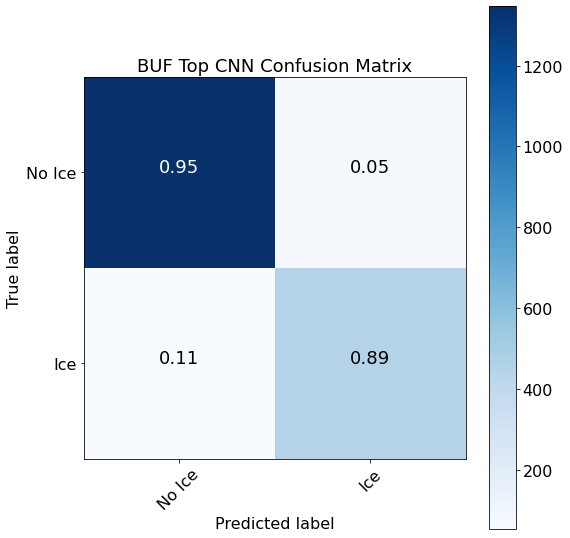

In [97]:
# Plot confusion matrix
if plotConfusion:
    
    print('Best BUF Train Accuracy: {:.1f}% and Test Accuracy: {:.1f}%'. \
         format(topCVBUF[0]*100., topTestBUF[0]*100.))    
    print('Best Params: ', topParamsBUF[0])
    print()
    
    YConfTitle = 'BUF Top CNN Confusion Matrix'
    cmatrix = confusion_matrix(YTestBUF, topPredictBUF[0])
    disp = plot_confusion_matrix(cmatrix, ['No Ice','Ice'],
                                 cTitle=YConfTitle) 
        
    if saveConfusion:
        fileName = savePrefix + 'BUF_TopCNNConf.png'
        plt.savefig(fileName,bbox_inches='tight')
        
    
    print('Best DTW Train Accuracy: {:.1f}% and Test Accuracy: {:.1f}%'. \
         format(topCVDTW[0]*100., topTestDTW[0]*100.))    
    print('Best Params: ', topParamsDTW[0])
    print()
    
    YConfTitle = 'DTW Top CNN Confusion Matrix'
    cmatrix = confusion_matrix(YTestDTW, topPredictDTW[0])
    disp = plot_confusion_matrix(cmatrix, ['No Ice','Ice'],
                                 cTitle=YConfTitle) 
        
    if saveConfusion:
        fileName = savePrefix + 'DTW_TopCNNConf.png'
        plt.savefig(fileName,bbox_inches='tight')

In [95]:
# Plot Top Accuracies
if plotAccs:

    # Create plots
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,7))
    xs = np.arange(1,topN+1,dtype=int)
    
    axes[0].plot(xs,dfResults['BUF_Test'],color='b',label='BUF')
    axes[0].plot(xs,dfResults['DTW_Test'],color='r',label='DTW')
    axes[0].set_title('Top {} Test Performances'.format(topN))
    axes[0].xaxis.set_ticks([2,4,6,8,10,12])
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Balanced Accuracy')
    axes[0].legend(loc='lower left')

    axes[1].plot(xs,dfResults['BUF_Train'],color='b',label='BUF')
    axes[1].plot(xs,dfResults['DTW_Train'],color='r',label='DTW')
    axes[1].set_xlabel("Model")
    axes[1].set_title('Corresponding {} Trains'.format(topN))
    fig.tight_layout()
        
    if saveAccs:
        fileName = savePrefix + 'BOTH_TopAccs.png'
        plt.savefig(fileName,bbox_inches='tight')

In [2]:
# Plot Top Model Setups
if plotTopModels:
    fileName = savePrefix + 'BUF_model'
    plot_model_diagram(topParamsBUF[0], fileName)
    
    fileName = savePrefix + 'DTW_model'
    plot_model_diagram(topParamsDTW[0], fileName)

# 6 Cross Model Analysis

In [22]:
inFileBUF = './cnn_save/BUF_CrossTestResults.pkl'
inFileDTW = './cnn_save/DTW_CrossTestResults.pkl'

loadCross = True
plotCrossConf = True
saveCrossConf = True
plotCrossHist = True
saveCrossHist = True
savePrefix = './cnn_figs/'

In [23]:
# Load Results
if loadCross:
    # BUF---
    with open(inFileBUF, 'rb') as handle:
        allTemp = pickle.load(handle)
        
    crResultsBUF = allTemp[0]
    crHistoryBUF = allTemp[1]
    crPredictBUF = allTemp[2]
    
    # DTW---    
    with open(inFileDTW,'rb') as handle:
        allTemp = pickle.load(handle)
    crResultsDTW = allTemp[0]
    crHistoryDTW = allTemp[1]
    crPredictDTW = allTemp[2]


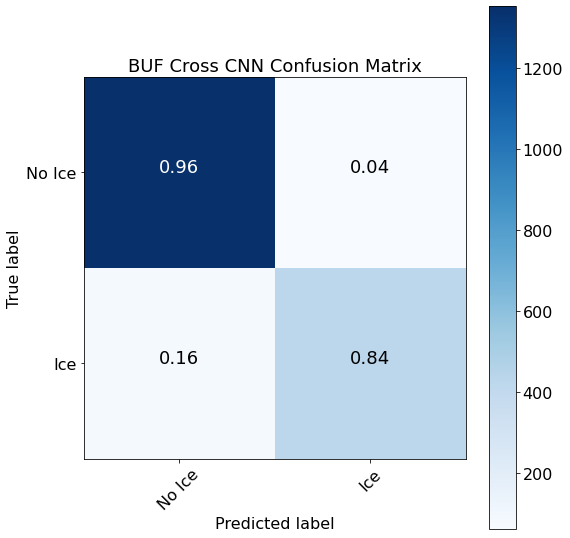

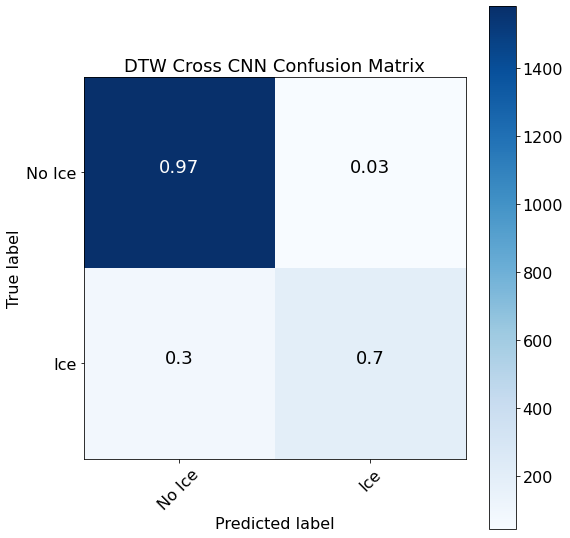

In [41]:
# Plot Cross-Model Confusion Matrices
if plotCrossConf:
    crmatrix = np.array([[crResultsBUF['tn'], crResultsBUF['fp']],
                        [crResultsBUF['fn'], crResultsBUF['tp']]])
    YConfTitle = 'BUF Cross CNN Confusion Matrix'
    disp = plot_confusion_matrix(crmatrix, ['No Ice','Ice'],
                                 cTitle=YConfTitle)
    if saveCrossConf:
        fileName = savePrefix + 'BUF_CrossCNNConf.png'
        plt.savefig(fileName,bbox_inches='tight')
    
    crmatrix = np.array([[crResultsDTW['tn'], crResultsDTW['fp']],
                        [crResultsDTW['fn'], crResultsDTW['tp']]])
    YConfTitle = 'DTW Cross CNN Confusion Matrix'
    disp = plot_confusion_matrix(crmatrix, ['No Ice','Ice'],
                                 cTitle=YConfTitle)
    if saveCrossConf:
        fileName = savePrefix + 'DTW_CrossCNNConf.png'
        plt.savefig(fileName,bbox_inches='tight')

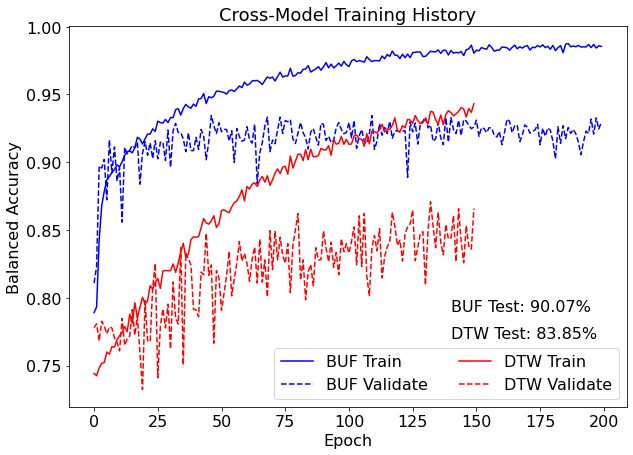

In [124]:
# Plot Cross-Model History
if plotCrossHist:
    crColors = ['b','r']
    #crColors = ['mediumseagreen','darkorange']
    
    balAccBUF = crHistoryBUF['balAcc']
    balAccDTW = crHistoryDTW['balAcc']
    vbalAccBUF = crHistoryBUF['val_balAcc']
    vbalAccDTW = crHistoryDTW['val_balAcc']
    
    epochsBUF = np.arange(len(balAccBUF))
    epochsDTW = np.arange(len(balAccDTW))
    
    fig, ax = plt.subplots(figsize=(10,7))
    ax.plot(epochsBUF, balAccBUF, label='BUF Train', color=crColors[0])
    ax.plot(epochsBUF, vbalAccBUF, label='BUF Validate', 
            color=crColors[0], linestyle='dashed')
    ax.plot(epochsDTW, balAccDTW, label='DTW Train', color=crColors[1])
    ax.plot(epochsDTW, vbalAccDTW, label='DTW Validate', 
            color=crColors[1], linestyle='dashed')
    
    myTAcc = 'DTW Test: {:.2f}%'.format(crResultsDTW['balAcc']*100.)
    ax.text(140, 0.77, myTAcc, fontsize=16)
    myTAcc = 'BUF Test: {:.2f}%'.format(crResultsBUF['balAcc']*100.)
    ax.text(140, 0.79, myTAcc, fontsize=16)
    plt.title("Cross-Model Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Balanced Accuracy")
    plt.legend(ncol=2)
    
    
    if saveCrossHist:
        fileName = savePrefix + 'CrossHistory.png'
        plt.savefig(fileName,bbox_inches='tight')